<a href="https://colab.research.google.com/github/S4b3/PITC-21-22/blob/main/classification_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sync Code

Clone the GitHub Repo


In [ ]:
!cd /content
!git clone https://github.com/szappac20/training_camp_21_22.git -b develop

Cloning into 'training_camp_21_22'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 22 (delta 4), reused 17 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), done.


`Move to the Python Project root folder` and install requirements

In [ ]:
%cd /content/training_camp_21_22
%pip install --upgrade -r requirements.txt -qqq

/content/training_camp_21_22
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 43.4 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 554 kB 29.5 MB/s 
     |████████████████████████████████| 13.1 MB 494 kB/s 
     |████████████████████████████████| 1.1 MB 29.7 MB/s 
     |████████████████████████████████| 15.8 MB 30.8 MB/s 
     |████████████████████████████████| 1.6 MB 45.4 MB/s 
     |████████████████████████████████| 438 kB 30.7 MB/s 
     |████████████████████████████████| 5.8 MB 40.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Download Dataset from Kaggle competition

Download dataset from Kaggle competition pitc-2122-clustering

In [ ]:
!mkdir -p ~/.kaggle

Download the kaggle.json token file

In [ ]:
!gdown 1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN -O  ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1w81nWRhAr1E_hX9OSncuMxlCefxnP2zN
To: /root/.kaggle/kaggle.json
100% 74.0/74.0 [00:00<00:00, 56.6kB/s]


Download the input file (training and test)

In [ ]:
!mkdir -p data/task_1

In [ ]:
%cd data/task_1

/content/training_camp_21_22/data/task_1


In [ ]:
!kaggle competitions download -c pitc-2122-clustering
!unzip pitc-2122-clustering.zip

 48% 11.0M/23.1M [00:00<00:00, 115MB/s]
100% 23.1M/23.1M [00:00<00:00, 159MB/s]
Archive:  pitc-2122-clustering.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


# Import packages

Move back to the Python project folder 

In [ ]:
%cd /content/training_camp_21_22

/content/training_camp_21_22


Set the Python Path variable to the source folder

In [ ]:
import sys
import os

sys.path.append("training_camp_21_22")

Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow_decision_forests as tfdf

import training_camp_21_22.config
import training_camp_21_22.data.commercial_offer
import training_camp_21_22.models
import training_camp_21_22.view.classification

# Preprocess Data

Dowload the data

In [ ]:
# Parse the csv file with json entries

def convert_json_2_pd(json_input_path):
    """
    Read the csv file and extract from json events
    any feature useful to classify the consumer consumption profile 
    """

    #TODO: THIS IS JUST A FAKE RESULT
    num_users = 100
    features_df = pd.DataFrame({
        "user": range(num_users),
        "f1": np.random.normal(loc=60., scale=20., size=num_users),
        "f2": np.random.normal(loc=60., scale=20., size=num_users),
        "f3": np.random.normal(loc=60., scale=20., size=num_users)})
    
    labels_df = pd.DataFrame({
        "user": range(num_users),
        "cluster": np.random.randint(0, 3, size=num_users)})

    return features_df, labels_df

features_df, labels_df = convert_json_2_pd(json_input_path="")

Let's have a look at the collected data!

In [ ]:
features_df.head()

,user,f1,f2,f3
0,0,63.773756,57.779517,49.172062
1,1,65.241985,84.120170,57.415482
2,2,64.058132,70.720680,120.889262
3,3,48.216510,39.759390,82.717919
4,4,37.150495,46.460181,42.381139


In [ ]:
labels_df.head()

,user,cluster
0,0,2
1,1,0
2,2,0
3,3,2
4,4,1


Load the commercial offers

In [ ]:
#Label 0
mono_oraria = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.28, "f2": 0.28, "f3": 0.28}, name="mono_oraria")

# Label 1
serale = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.31, "f2": 0.26, "f3": 0.26}, name="serale")

# Lael 2
notturna = training_camp_21_22.data.commercial_offer.CommercialOffer(
    price_dict={"f1": 0.56, "f2": 0.56, "f3": 0.}, name="notturna")

commercial_offers = [mono_oraria, serale, notturna]
class_names = [co.name for co in commercial_offers]

#Baseline Classifier

The label is computed by "extending" the mean consumptions over the whole year

In [ ]:
def project_over_year(df, commercial_offers):
    
    def best_projected_offer(row):
        columns = [co.name for co in commercial_offers]
        cluster = np.argmin(row[columns])
        return cluster
        
    year_projection = 12 * df.groupby(by=["user"]).mean()

    for offer in commercial_offers:
        year_projection[offer.name] = year_projection.apply(
            offer.compute_yearly_cost, axis=1)

    year_projection["cluster"] = year_projection.apply(
        best_projected_offer, axis=1)
    year_projection = year_projection.drop(
        [co.name for co in commercial_offers], axis=1)

    return year_projection


year_projection_df = project_over_year(
    features_df, commercial_offers)

Let's have a look at the projection!

In [ ]:
year_projection_df.head()

,f1,f2,f3,cluster
user,,,,
0,765.285078,693.354202,590.064748,1
1,782.903821,1009.442038,688.985789,1
2,768.697583,848.648165,1450.671149,1
3,578.598126,477.112678,992.615033,1
4,445.805943,557.522171,508.573662,1


Plotting the confusion matrix

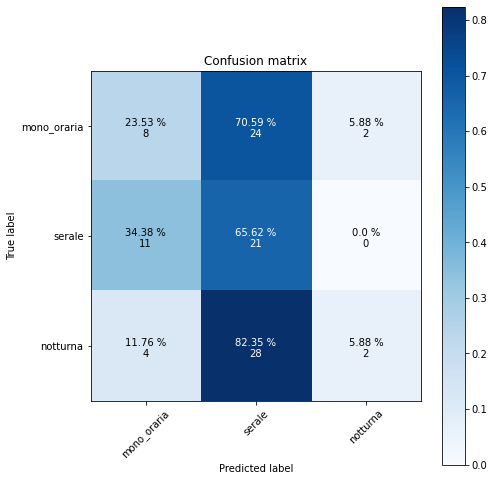

In [ ]:
cm = confusion_matrix(
    labels_df["cluster"], year_projection_df["cluster"])

# Log the confusion matrix as an image summary
figure = training_camp_21_22.view.classification.plot_cm_with_labels(
    cm, class_names=class_names);

# Random Forest Classifier

Random Forest model

# Submit solution to Kaggle competition

In [ ]:
test_submission = pd.DataFrame({
    "user": year_projection_df.index,
    "cluster": year_projection_df["cluster"]})
print(test_submission.head(10))
print(test_submission.shape)

      user  cluster
user               
0        0        1
1        1        1
2        2        1
3        3        1
4        4        1
5        5        1
6        6        0
7        7        1
8        8        0
9        9        0
(100, 2)


Create a termporary folder for submissions

In [ ]:
!mkdir -p submissions

In [ ]:
rf_labels_path = "submissions/baseline.csv"
test_submission.to_csv(rf_labels_path, index=False)

In [ ]:
!kaggle competitions submit -c pitc-2122-clustering -f "submissions/baseline.csv" -m "Baseline classification"

100% 503/503 [00:00<00:00, 2.32kB/s]
Successfully submitted to PITC 21/22 - Clustering